<a href="https://colab.research.google.com/github/ValeriiaLadyhina/BI_birds_classifier/blob/main/BIRDS_400_SPECIES_IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIRDS 400 - SPECIES IMAGE CLASSIFICATION

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving ResNet18_fine_tune_final.pth to ResNet18_fine_tune_final.pth
Saving ResNet18_fine_tune_best.pth to ResNet18_fine_tune_best.pth
Saving kaggle.json to kaggle.json


In [12]:
! pip install kaggle

In [13]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
!kaggle datasets download -d gpiosenka/100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
! unzip -q 100-bird-species.zip

replace EfficientNetB4-BIRDS-0.99.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Data

https://www.kaggle.com/datasets/gpiosenka/100-bird-species/code?resource=download

We need to add some description

**Обрезаное описание с каггла:**

*Data set of 400 bird species. 58388 training images, 2000 test images(5 images per species) and 2000 validation images(5 images per species). This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image. As a result even a moderatly complex model will achieve training and test accuracies in the mid 90% range.*

*All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 400 sub directories, one for each bird species. The data set also include a file Bird Species.csv. This cvs file contains three columns. The filepaths column contains the file path to an image file. The labels column contains the class name associated with the image file. The Bird Species.csv file if read in using df= pandas.birdscsv(Bird Species.csv) will create a pandas dataframe which then can be split into traindf, testdf and validdf dataframes to create your own partitioning of the data into train, test and valid data sets.*

In [ ]:
import pickle
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

from os.path import join
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import nn
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import functional as F

from sklearn.metrics import classification_report

Some variables

In [ ]:
DATA_PATH = "/content/"
TRAIN_PATH = '/content/train/'
VALID_PATH = '/content/valid/'
TEST_PATH = '/content/test/'
RESCALE_SIZE = 224, 224 # В зависимости от типа нейросети этот параметр можно поменять
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
mean = torch.Tensor([0.4704, 0.4669, 0.3898])
std = torch.Tensor([0.2392, 0.2329, 0.2546])

print(f"Using device: {DEVICE}")

### Mean and std calculation

Чтобы нормализовать данные, надо узнать среднее и стандартное. Можно погуглить, можно взять параметры для ImageNet (`([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`) но я загрузила тренировочные данные без всякой трансформации (класс `CheckSet()`) и в лоб прошлась по всем изображениям

In [ ]:
class CheckSet(Dataset):
  def __init__(self, files):
        super().__init__()

        self.files = sorted(list(files))
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)
  
  def __len__(self):
        return self.len_

  def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

  def __getitem__(self, index):
        transform = transforms.Compose([
                        #transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        #transforms.Normalize([0.572], [0.048])
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [ ]:
train_files = list(Path('/content/train').rglob("*.jpg"))

In [ ]:
check_set = CheckSet(train_files)
check_loader = DataLoader(check_set, batch_size = 1000, shuffle = False)

mean & std

In [ ]:
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
picts = 0

for inputs, labels in tqdm(check_loader):
    psum    += inputs.sum(dim=(0,2,3))
    psum_sq += (inputs ** 2).sum(dim=(0,2,3))
    picts += inputs.shape[0]

In [ ]:
n_pxls = picts * 224 * 224

mean = psum / n_pxls
std  = torch.sqrt((psum_sq / n_pxls) - (mean ** 2))

print('mean: '  + str(mean))
print('std:  '  + str(std))

mean: tensor([0.4704, 0.4669, 0.3898])
std:  tensor([0.2392, 0.2329, 0.2546])


In [ ]:
mean = torch.Tensor([0.4704, 0.4669, 0.3898])
std = torch.Tensor([0.2392, 0.2329, 0.2546])

### Some metadata

In [ ]:
pd.read_csv('class_dict.csv').head()

,class_index,class,height,width,scale by,Offset
0,0,ABBOTTS BABBLER,112,112,1,0
1,1,ABBOTTS BOOBY,112,112,1,0
2,2,ABYSSINIAN GROUND HORNBILL,112,112,1,0
3,3,AFRICAN CROWNED CRANE,112,112,1,0
4,4,AFRICAN EMERALD CUCKOO,112,112,1,0


In [ ]:
birds_df = pd.read_csv('birds.csv')
birds_df.head()

,class index,filepaths,labels,data set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [ ]:
pd.read_csv(f'{DATA_PATH}/birds latin names.csv').head()

,class_index,class,SCIENTIFIC NAME
0,0,ABBOTTS BABBLER,Malacocincla abbotti
1,1,ABBOTTS BOOBY,Papasula abbotti
2,2,ABYSSINIAN GROUND HORNBILL,Bucorvus abyssinicus
3,3,AFRICAN CROWNED CRANE,Balearica regulorum
4,4,AFRICAN EMERALD CUCKOO,Chrysococcyx cupreus


Проверим баланс классов (это есть в описании, но тут наглядный график)

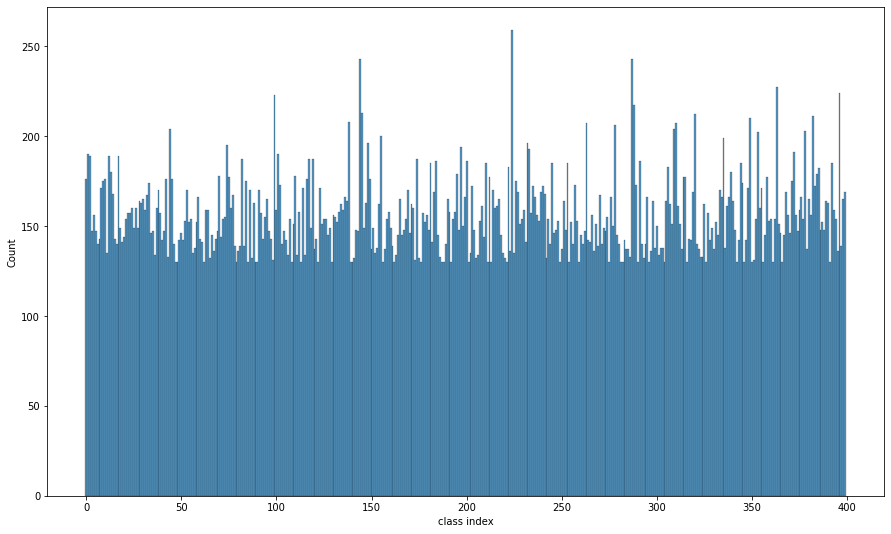

In [ ]:
plt.rcParams['figure.figsize'] = 15, 9
sns.histplot(data=birds_df, x='class index', discrete=True);

At least 130 images for every class, so I think we can say that data is balanced

In [ ]:
class_df = pd.read_csv('class_dict.csv')
labels_dict = dict(zip(class_df.class_index, class_df['class'])) # словарь со всеми метками

In [ ]:
labels_dict[9]

'ALEXANDRINE PARAKEET'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


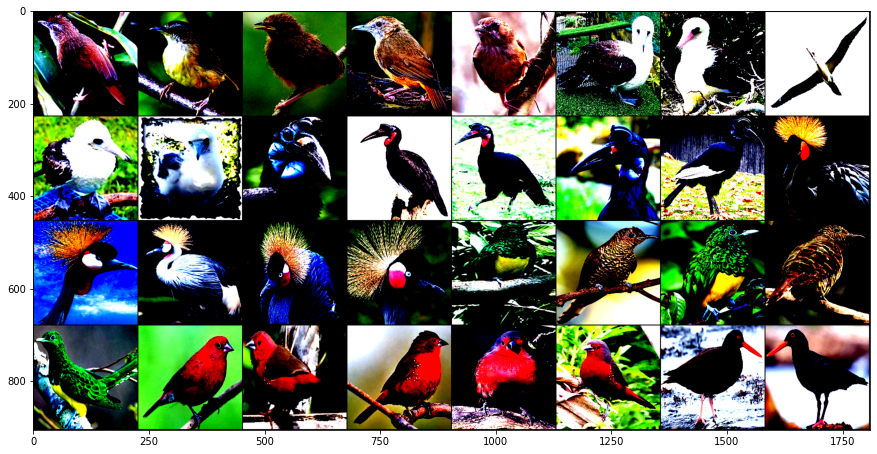

In [17]:
inputs, classess = next(iter(valloader))

out = torchvision.utils.make_grid(inputs[:32])

plt.rcParams["figure.figsize"] = [15, 10]
plt.imshow(out.numpy().transpose((1, 2, 0)))

### Dataset creation (ImageFolder)

In [ ]:
transform_train = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.RandomHorizontalFlip(), # на каггле так тоже делают
                        transforms.RandomPerspective(), # перспектива, мб стоит убрать
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std) # [0.4704, 0.4669, 0.3898], [0.2392, 0.2329, 0.2546]
                        ])
transform_valid = transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                        ])

In [ ]:
trainset = ImageFolder(root=TRAIN_PATH, transform=transform_train)
valset = ImageFolder(root=VALID_PATH, transform=transform_valid)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

### Trainer class

In [18]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=-1)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

        self.best_model_wts = self.model.state_dict()
        self.best_acc = 0.0

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        if epoch_metric > self.best_acc:
                self.best_acc = epoch_metric
                self.best_model_wts = model.state_dict()

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

### Naive Stupid model

Теперь пришло время для маленькой тупой модели моего собственного производства :)

In [ ]:
class MyBirdNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extr = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=12, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=4, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU()
        )

        self.classfr = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=400)
        )

    def forward(self,x):
        x = self.feature_extr(x)
        x = torch.flatten(x, 1)
        logits = self.classfr(x)

        return logits

In [ ]:
model = MyBirdNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score)
trainer.fit()

Training: batch 229 out of 229
Validation: batch 8 out of 8

Epoch 1 out of 10: Train loss = 5.404355777923717, validation loss = 4.506807625293732 
                                         Train metric = 0.02474823593889155, validation metric = 0.0775

Training: batch 229 out of 229
Validation: batch 8 out of 8

Epoch 2 out of 10: Train loss = 4.398141352890881, validation loss = 3.866814523935318 
                                         Train metric = 0.09027539905460026, validation metric = 0.14

Training: batch 229 out of 229
Validation: batch 8 out of 8

Epoch 3 out of 10: Train loss = 3.784081834893039, validation loss = 2.9986384212970734 
                                         Train metric = 0.16099198465438103, validation metric = 0.1975

Training: batch 229 out of 229
Validation: batch 8 out of 8

Epoch 4 out of 10: Train loss = 3.373984491981273, validation loss = 2.9812601804733276 
                                         Train metric = 0.21545523052682058, validation m

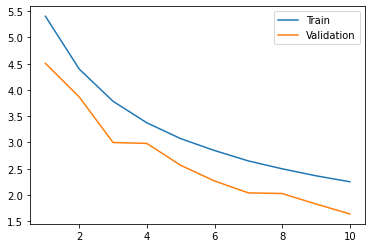

In [ ]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

Нууу, можно увеличить количество эпох, но я не верю

### Pretrained model (vgg19)

In [ ]:
# If you want you can use ImageNet mean and std values
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.avgpool.requires_grad = True

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 400)
)
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
model_trainer = Trainer(model, 25, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 1 out of 25: Train loss = 1.2611971806983697, validation loss = 0.3216600832529366 
                                         Train metric = 0.7021305747756388, validation metric = 0.415

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 2 out of 25: Train loss = 0.22470054416004304, validation loss = 0.2514745786320418 
                                         Train metric = 0.899534150852915, validation metric = 0.4015

Training: batch 169 out of 913

KeyboardInterrupt: ignored

### ResNet

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.layer4[1].requires_grad = True
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 400)
model = model.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [ ]:
model_trainer = Trainer(model, 25, criterion, optimizer, trainloader, valloader, DEVICE, accuracy_score, scheduler=scheduler)
model_trainer.fit()

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 1 out of 25: Train loss = 4.081046890716302, validation loss = 2.366735689342022 
                                         Train metric = 0.3543365075015414, validation metric = 0.694

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 2 out of 25: Train loss = 2.069993457553943, validation loss = 1.2880121637135744 
                                         Train metric = 0.7007090498047543, validation metric = 0.8355

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 3 out of 25: Train loss = 1.4207725200438943, validation loss = 0.8999661896377802 
                                         Train metric = 0.7689765020209632, validation metric = 0.8685

Training: batch 913 out of 913
Validation: batch 32 out of 32

Epoch 4 out of 25: Train loss = 1.1303070422592456, validation loss = 0.6919344710186124 
                                         Train metric = 0.7962252517640611, vali

In [ ]:
model.state_dict()

In [ ]:
torch.save(model_trainer.best_model_wts, "ResNet18_fine_tune_best.pth")

In [ ]:
torch.save(model.state_dict(), "ResNet18_fine_tune_final.pth")

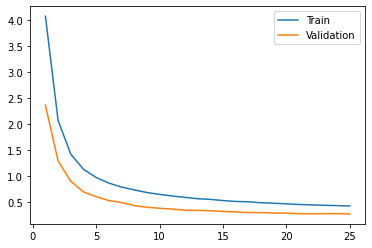

In [ ]:
sns.lineplot(y=model_trainer.train_losses, x=range(1, 26), label="Train")
sns.lineplot(y=model_trainer.valid_losses, x=range(1, 26), label="Validation")

plt.show()

### Model loading

In [19]:
WEIGHTS_PATH = "/content/ResNet18_fine_tune_best.pth"

In [21]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 400)
model.load_state_dict(torch.load(WEIGHTS_PATH))
model = model.to(DEVICE)

### Test

In [22]:
testset = ImageFolder(TEST_PATH, transform=transform_valid)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
model.eval()
    
test_epoch_accuracy = []
epoch_labels = []
epoch_preds = []
get_probs = nn.Softmax(dim=-1)

for images, labels in testloader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    out = model(images)
    out = get_probs(out)
    _, preds = torch.max(out.data, 1)
    epoch_labels += list(labels.detach().cpu())
    epoch_preds += list(preds.detach().cpu())


test_accuracy = accuracy_score(epoch_labels, epoch_preds)

print(f"Test Accuracy = {test_accuracy}")

Test Accuracy = 0.9455
